In [6]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def dropna(x):
    return list(filter(lambda x: x > -np.inf, x))

path = '../data/VehicleID_152851_DriverID_22209/VehicleID_152851_DriverID_22209/File_ID_1229.csv'
data = pd.read_csv(path, na_values=" ")

## Ideas


### Columns to use

* vtti.speed_gps
* vtti.speed_network
* vtti.pedal_brake_state
* vtti.pedal_gas_state
* vtti.engine_rpm
* vtti.accel (\_x, \_y, \_z)


* **vtti.video_frame**
    * Always necessary

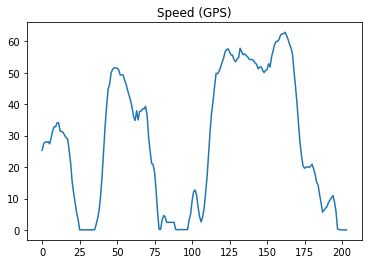

In [59]:
plt.plot(dropna(data['vtti.speed_gps']))
plt.title('Speed (GPS)')
plt.show()

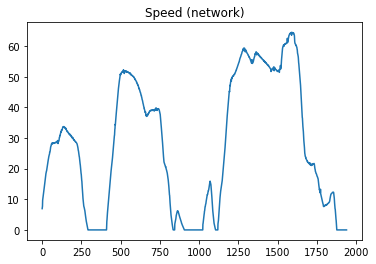

In [58]:
plt.plot(dropna(data['vtti.speed_network']))
plt.title('Speed (network)')
plt.show()

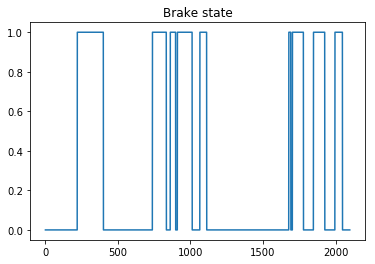

In [57]:
plt.plot(dropna(data['vtti.pedal_brake_state']))
plt.title('Brake state')
plt.show()

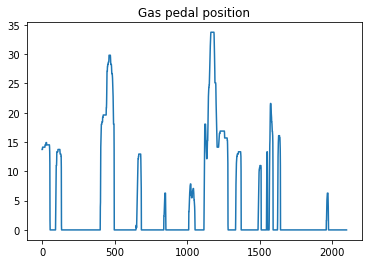

In [56]:
plt.plot(dropna(data['vtti.pedal_gas_position']))
plt.title('Gas pedal position')
plt.show()

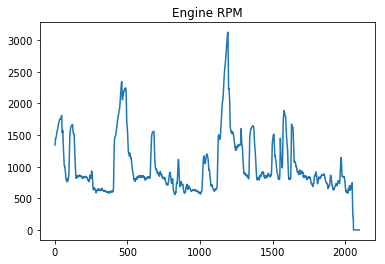

In [55]:
plt.plot(dropna(data['vtti.engine_rpm_instant']))
plt.title('Engine RPM')
plt.show()

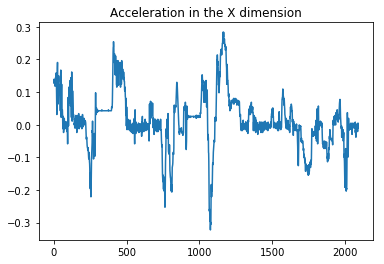

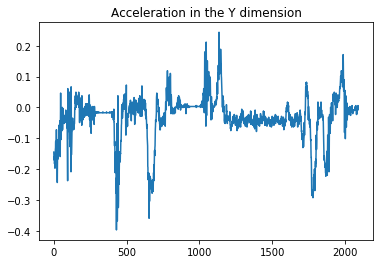

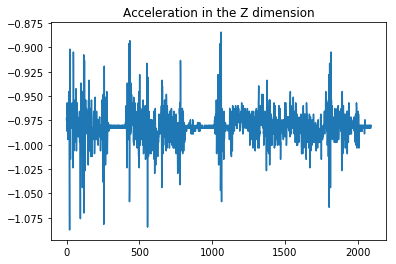

In [54]:
accel_x = dropna(data['vtti.accel_x'])
accel_y = dropna(data['vtti.accel_y']) 
accel_z = dropna(data['vtti.accel_z']) 

plt.plot(accel_x)
plt.title('Acceleration in the X dimension')
plt.show()

plt.plot(accel_y)
plt.title('Acceleration in the Y dimension')
plt.show()

plt.plot(accel_z)
plt.title('Acceleration in the Z dimension')
plt.show()

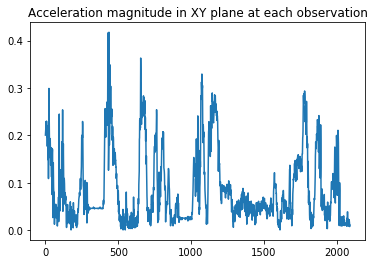

In [53]:
accel = list()
for i in range(len(accel_x)):
    accel.append((accel_x[i] ** 2 + accel_y[i] ** 2)  ** .5)
plt.plot(accel)
plt.title('Acceleration magnitude in XY plane at each observation')
plt.show()

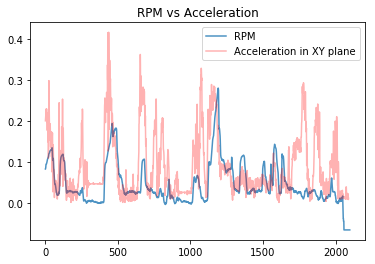

In [51]:
plt.plot(dropna((data['vtti.engine_rpm_instant'] - 600)/9000), alpha = 0.8)
plt.plot(accel, c='r', alpha = .3)
plt.legend(['RPM', 'Acceleration in XY plane'])
plt.title('RPM vs Acceleration')
plt.show()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
          ...   
2093         NaN
2094         NaN
2095         NaN
2096         NaN
2097    0.018518
2098         NaN
2099         NaN
2100         NaN
2101         NaN
2102         NaN
2103         NaN
2104         NaN
2105         NaN
2106         NaN
2107    0.018518
2108         NaN
2109         NaN
2110         NaN
2111         NaN
2112         NaN
2113         NaN
2114         NaN
2115         NaN
2116         NaN
2117         NaN
2118         NaN
2119         NaN
2120         N